# Table of Contents

#### 1. Import libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
            Subset Creation
            Missing Values
            Duplicate Values
            Index Reset
#### 3. Line Chart
#### 4. Decompose the data
#### 5. Conduct a Dickey_Fuller test
            Interpretation
            Autocorrelation
                Interpretation
#### 6. Stationarizing the US Grain Supply data
            Interpretation
#### 7. Check the data's autocorrelations
            Interpretation
#### 8. Export data

## 1. Import Libraries and Data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
# create shortcut path
path = r"C:\Users\HP\Documents\09-2024 Agriculture Crop Analysis"

In [6]:
# import dataset
data = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'us_crop_data.csv'), index_col = False)

In [7]:
data.head()

,code,report_month,region,commodity,item,year,period,value
0,GRAINS_US_08,2020-10,United States,Total Grains 4/,Total Supply,2018/19,Annual,532.30
1,GRAINS_US_08,2020-09,United States,Total Grains 4/,Total Supply,2018/19,Annual,532.30
2,GRAINS_US_08,2020-08,United States,Total Grains 4/,Total Supply,2018/19,Annual,532.30
3,GRAINS_US_08,2020-07,United States,Total Grains 4/,Total Supply,2018/19,Annual,532.30
4,GRAINS_US_08,2020-06,United States,Total Grains 4/,Total Supply,2018/19,Annual,532.31


In [8]:
data.shape

(153, 8)

In [9]:
data.describe()

,value
count,153.000000
mean,498.039673
std,37.192451
min,412.940000
25%,479.500000
50%,506.000000
75%,516.870000
max,556.090000


## 2. Subsetting, wrangling, and cleaning time-series data

### Subset Creation

Before importing my data, I filtered down the data set in excel to remove the following...
- had the 'code' column to only show US grain values
- had the 'commodity' column to only show 'Total Grains 4/' and 'Total Grains 3/' to show the overall grain production in the US and not the individual grain supply
- had the 'item' column only show the 'Total Supply' to have a better visual of overall yield regardless of what purpose the grain was being used for (food, livestock)
- had the 'period' column only show the 'Annual' total supply
- removed the estimated and projected yields to only show the actual yield

I tried to create these subsets in python but found out the imported data via the API link was not importing all of the data compared to the downloadable data set from the website directly.

In [13]:
# removing columns to show only the 'report_month' and 'value'

df_month = data.drop(columns = ['code', 'region', 'commodity', 'item', 'year', 'period'])

In [14]:
df_month.head()

,report_month,value
0,2020-10,532.30
1,2020-09,532.30
2,2020-08,532.30
3,2020-07,532.30
4,2020-06,532.31


In [15]:
# removing columns to show only the 'year' and 'value'

df_year = data.drop(columns = ['code', 'report_month', 'region', 'commodity', 'item', 'period'])

In [16]:
df_year.head()

,year,value
0,2018/19,532.30
1,2018/19,532.30
2,2018/19,532.30
3,2018/19,532.30
4,2018/19,532.31


### Missing Values

In [18]:
# finding missing values in the df_month subset

df_month.isnull().sum()

report_month    0
value           0
dtype: int64

No missing values

In [20]:
# finding missing values in the df_year subset

df_year.isnull().sum()

year     0
value    0
dtype: int64

No missing values

### Duplicate Values

In [23]:
# checking for duplicates in the df_month subset

data_dups_month = df_month[df_month.duplicated()]

In [24]:
data_dups_month

,report_month,value


There are no duplicates

In [26]:
# checking for duplicates in the df_year subset specifically from the 'year' column
# I chose to check the year column and not the overall records because the year is what is needed to plot on the x-axis, not the value

data_dups_year = df_year[df_year.duplicated('year')]

In [27]:
data_dups_year

,year,value
1,2018/19,532.30
2,2018/19,532.30
3,2018/19,532.30
4,2018/19,532.31
5,2018/19,532.31
...,...,...
148,2021/22,513.41
149,2021/22,513.41
150,2021/22,513.41
151,2021/22,511.98


In [28]:
df_year.shape

(153, 2)

In [29]:
# Sort by 'year' and 'value' in descending order to keep the highest 'value' per year
df_year_sorted = df_year.sort_values(by=['year', 'value'], ascending=[True, False])

In [30]:
# Drop duplicates based on 'year', keeping the first (highest 'value' per year)
df_year_no_dups = df_year_sorted.drop_duplicates(subset='year', keep='first')

In [31]:
df_year_no_dups.shape

(14, 2)

In [32]:
df_year_no_dups.head(17)

,year,value
111,2008/09,461.70
100,2009/10,488.31
88,2010/11,479.50
77,2011/12,447.82
74,2012/13,414.06
53,2013/14,484.21
41,2014/15,499.23
29,2015/16,506.00
21,2016/17,556.09
6,2017/18,541.29


In [33]:
# Update the 'year' column to show only the first four digits (YYYY)
df_year_no_dups['year'] = df_year_no_dups['year'].str[:4]

In [34]:
df_year_no_dups.head(17)

,year,value
111,2008,461.70
100,2009,488.31
88,2010,479.50
77,2011,447.82
74,2012,414.06
53,2013,484.21
41,2014,499.23
29,2015,506.00
21,2016,556.09
6,2017,541.29


In [35]:
# check for missing values in updated subset
df_year_no_dups.isnull().sum()

year     0
value    0
dtype: int64

139 duplicates have been removed from the df_year subset. I will plot both subsets to see which one gives a more accurate time-series graph.

### Index Reset

In [62]:
# Reset index so that you can use the "report_month" column as a filter

df_month = df_month.reset_index()

In [64]:
df_month.head()

,index,report_month,value
0,0,2020-10,532.30
1,1,2020-09,532.30
2,2,2020-08,532.30
3,3,2020-07,532.30
4,4,2020-06,532.31


In [66]:
# Set the "report_month" column as the index for the df_month subset

from datetime import datetime

df_month['datetime'] = pd.to_datetime(df_month['report_month']) # Create a datetime column from "report_month"
df_month = df_month.set_index('datetime') # Set the datetime as the index of the dataframe.
df_month.drop(['report_month'], axis=1, inplace=True) # Drop the "report_month" column.
df_month.head()

,index,value
datetime,,
2020-10-01,0,532.30
2020-09-01,1,532.30
2020-08-01,2,532.30
2020-07-01,3,532.30
2020-06-01,4,532.31


In [70]:
# sort the date in ascending order

df_month.sort_index(ascending=True, inplace=True)

In [72]:
df_month.head()

,index,value
datetime,,
2011-01-01,114,461.70
2011-02-01,113,461.70
2011-03-01,112,461.70
2011-04-01,111,461.70
2011-05-01,116,488.31


In [63]:
# Reset index so that you can use the "year" column as a filter

df_year_no_dups = df_year_no_dups.reset_index()

In [74]:
df_year_no_dups.head()

,index,year,value
0,111,2008,461.70
1,100,2009,488.31
2,88,2010,479.50
3,77,2011,447.82
4,74,2012,414.06


In [76]:
# Set the "year" column as the index for the df_year_no_dups subset

from datetime import datetime

df_year_no_dups['datetime'] = pd.to_datetime(df_year_no_dups['year']) # Create a datetime column from "year"
df_year_no_dups = df_year_no_dups.set_index('datetime') # Set the datetime as the index of the dataframe.
df_year_no_dups.drop(['year'], axis=1, inplace=True) # Drop the "year" column.
df_year_no_dups.head()

,value
datetime,
2008-01-01,461.70
2009-01-01,488.31
2010-01-01,479.50
2011-01-01,447.82
2012-01-01,414.06


I have created two subsets to view on a line chart. One is based on month and the other is based on year.

## 3. Line Chart

### df_month chart

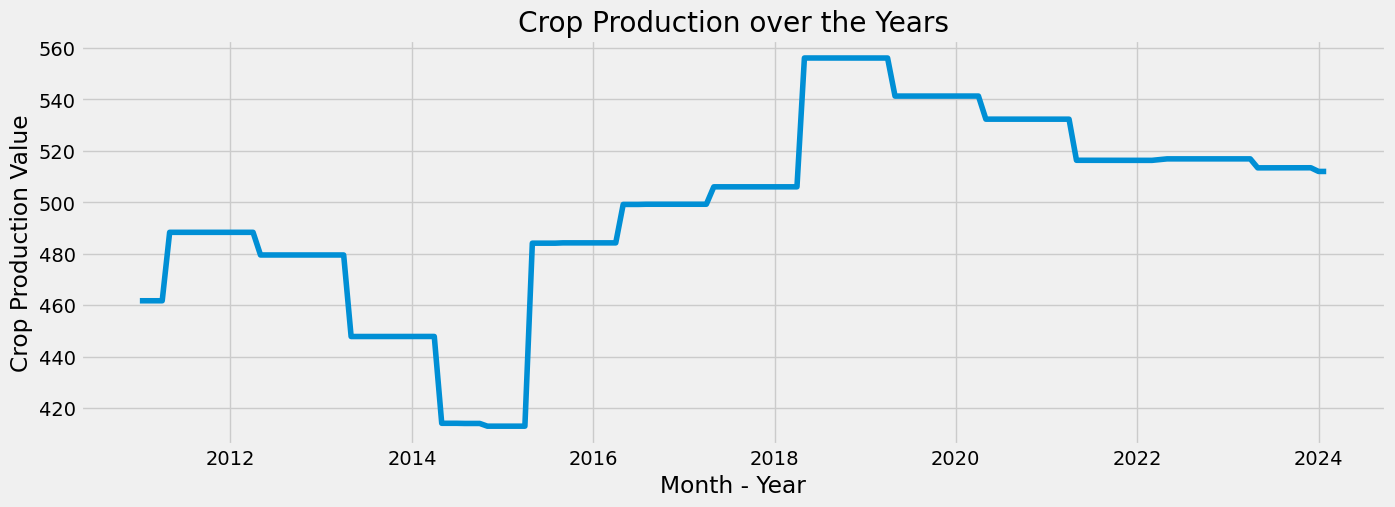

In [81]:
# plot the data set

# Plot the dataset with datetime index as the x-axis
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_month['value'])  # Only pass the y-axis data since the index is used as x-axis
plt.xlabel('Month - Year')  
plt.ylabel('Crop Production Value')
plt.title('Crop Production over the Years')
plt.show()

### df_year_no_dups chart

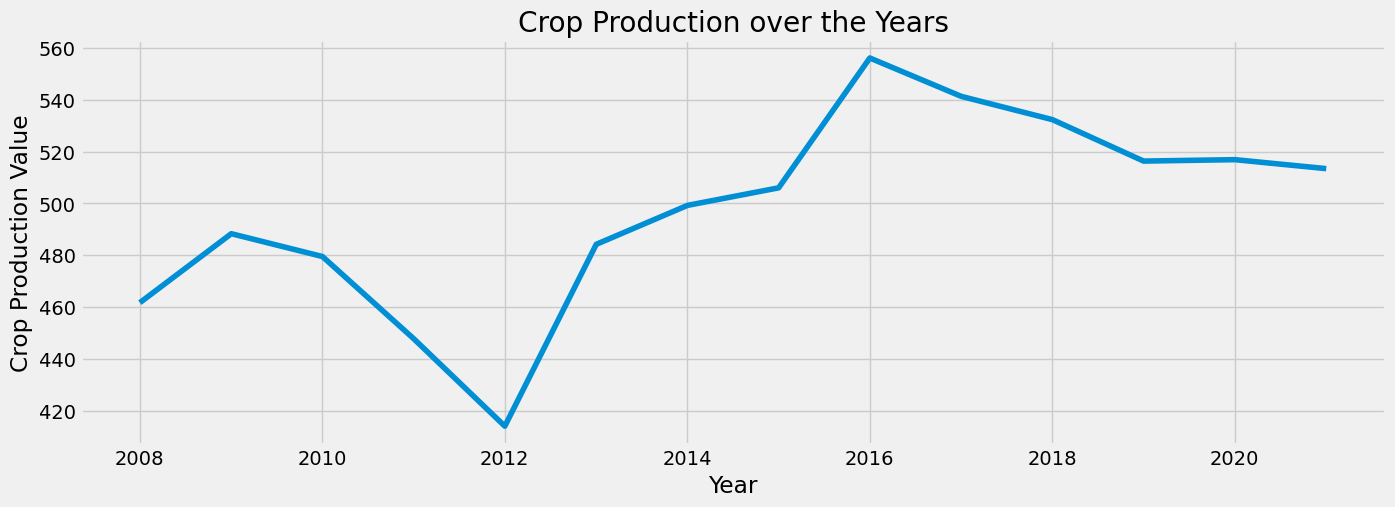

In [84]:
# plot the data set

# Plot the dataset with datetime index as the x-axis
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_year_no_dups['value'])  # Only pass the y-axis data since the index is used as x-axis
plt.xlabel('Year')  
plt.ylabel('Crop Production Value')
plt.title('Crop Production over the Years')
plt.show()

I have decided to more forward with the df_year_no_dups subset as it presents a more clear visual of the crop production over the years. Both graphs have similar trends, but the monthly graph still includes the duplicates leading to a possibly more inaccurate representation month over month.

By looking at the data more closely, the 'report_month' and 'period' columns do not match up. I am taking this as there is a lag in when the totals were reported, and feel the 'annual' column is more accurate to go with.

In [87]:
# Check for missing values

df_year_no_dups.isnull().sum() 

value    0
dtype: int64

In [89]:
# Check for duplicates

dups = df_year_no_dups.duplicated()
dups.sum()

# No dups!

0

## 4. Decompose the data

In [94]:
# Convert the 'datetime' index to the end of each year
df_year_no_dups.index = pd.to_datetime(df_year_no_dups.index).to_period('Y').end_time.normalize()

In [96]:
df_year_no_dups.head(20)

,value
datetime,
2008-12-31,461.70
2009-12-31,488.31
2010-12-31,479.50
2011-12-31,447.82
2012-12-31,414.06
2013-12-31,484.21
2014-12-31,499.23
2015-12-31,506.00
2016-12-31,556.09


In [100]:
# Set the frequency to yearly ('Y')
df_year_no_dups = df_year_no_dups.asfreq('Y')

In [104]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_year_no_dups['value'], model='additive', period=1)

In [106]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

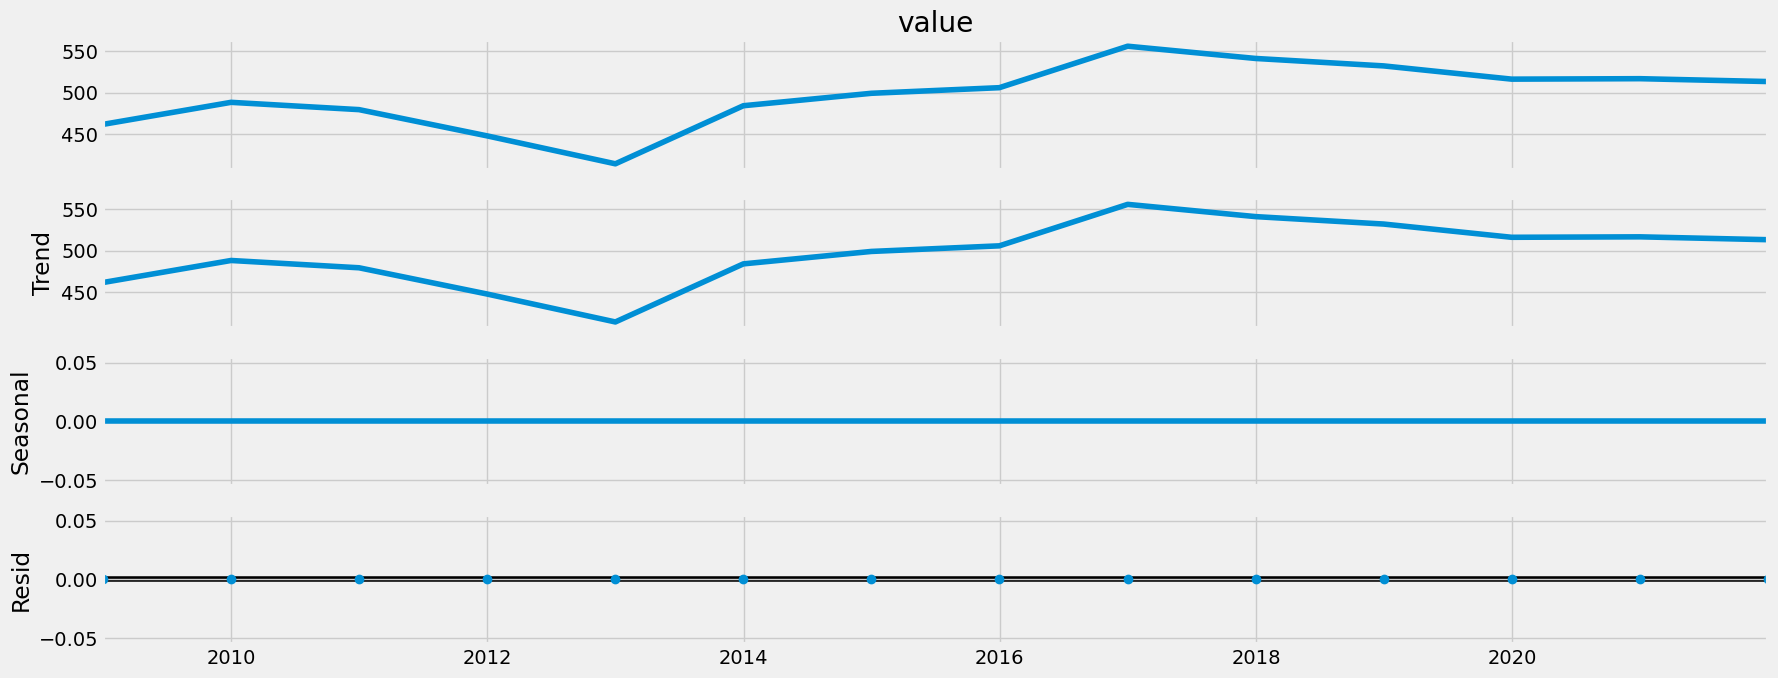

In [108]:
# Plot the separate components

decomposition.plot()
plt.show()

## 6. Conduct a Dickey_Fuller test

In [113]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_year_no_dups['value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.349459
p-value                         0.606252
Number of Lags Used             3.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


### Interpretation

**Test Statistic: -1.349**
- This value is compared against the critical values at different significance levels (1%, 5%, 10%) to determine if the data is stationary. The test statistic value is not more negative than any of the critical values and supports the conclusion that the data is non-stationary and we can't reject the null hypothesis. This means the time-series has trends or seasonality.

**p-value: 0.606**
- The p-value represents the probability of observing the test statistic under the null hypothesis. Since it is greater then 0.05 we fail to reject the null hypothesis, suggesting the series is not stationary.

### Autocorrelations

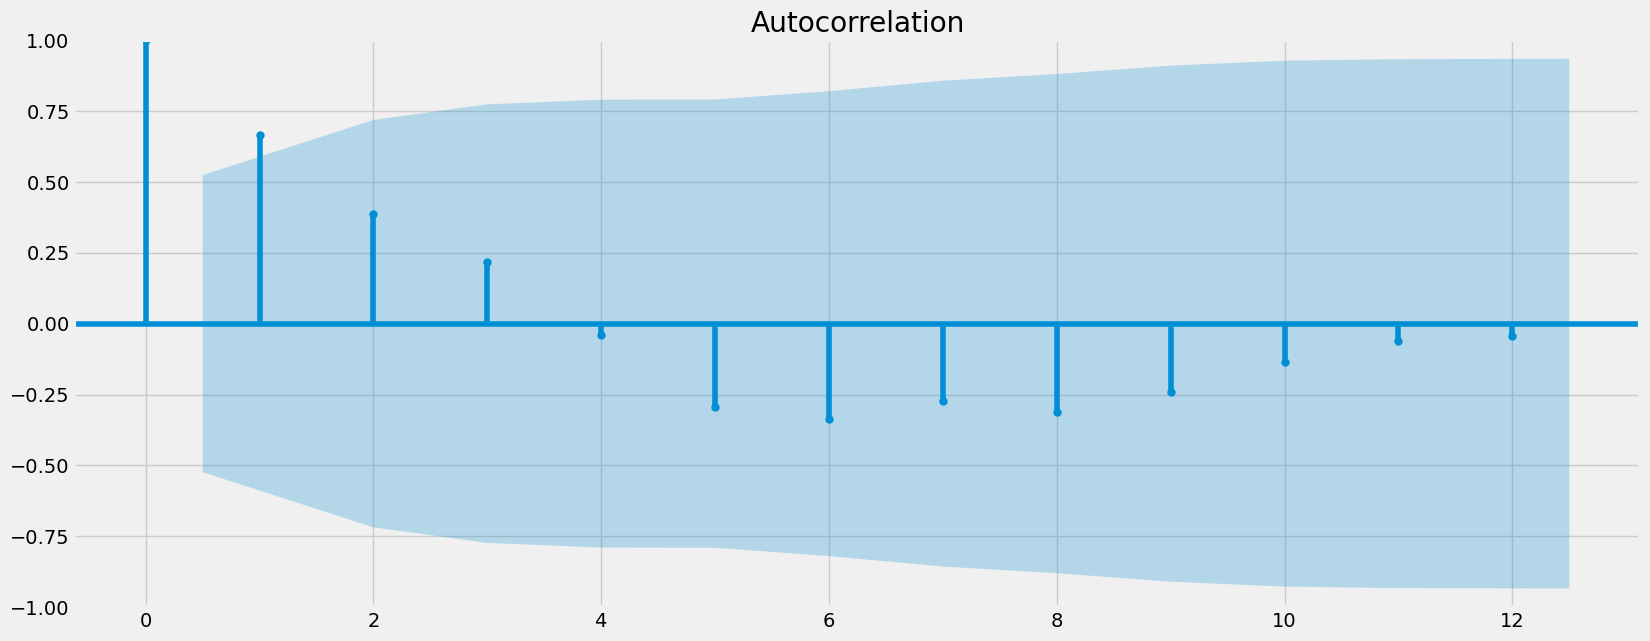

In [118]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_year_no_dups)
plt.show()

#### Interpretation

We have already determined the time-series is non-stationary, but since only a few  lags exceed the confidence level the series does not exhibit strong autocorrelation. This can imply that the time-series is less likely to have strong seasonal patterns.

## 6. Stationarizing the US Grain Supply data

In [128]:
data_diff = df_year_no_dups - df_year_no_dups.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [130]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [132]:
data_diff.head()

,value
datetime,
2009-12-31,26.61
2010-12-31,-8.81
2011-12-31,-31.68
2012-12-31,-33.76
2013-12-31,70.15


In [134]:
data_diff.columns

Index(['value'], dtype='object')

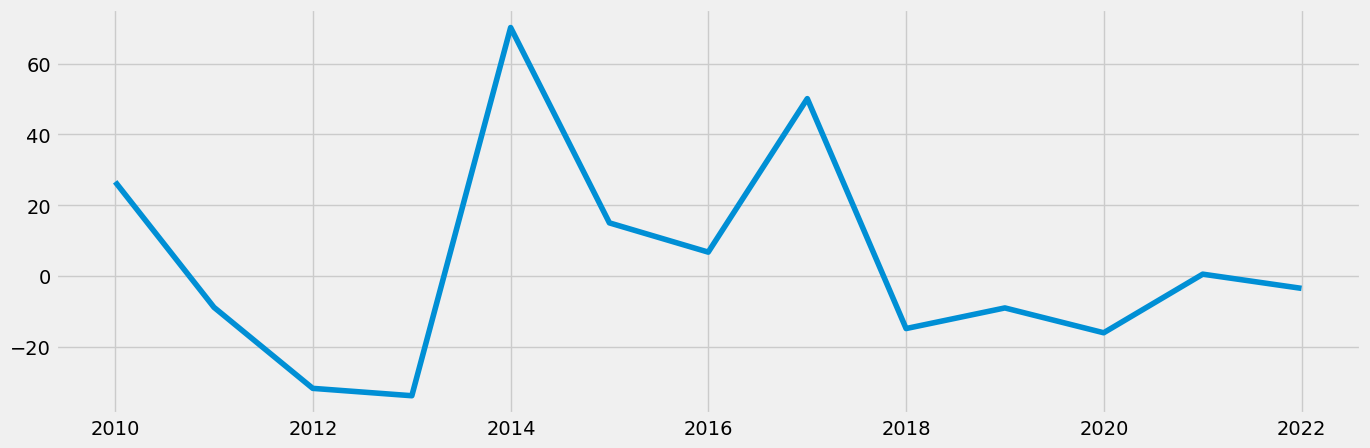

In [136]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [138]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.341970
p-value                         0.013104
Number of Lags Used             0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


### Interpretation

**Test Statistic: -3.341**
- The test statistic is more negative than the 5% and 10% critical values. This suggests that at the 5% and 10% significance levels, we can reject the null hypothesis of non-stationary.

**p-value: 0.013**
- The p-value is less than 0.05, which further supports rejecting the null hypothesis of non-stationarity at the 5% level. This implies that the series does not exhibit a strong trend or seasonal pattern and can be analyzed with methods that assume stationarity.

## 7. Check the data's autocorrelations

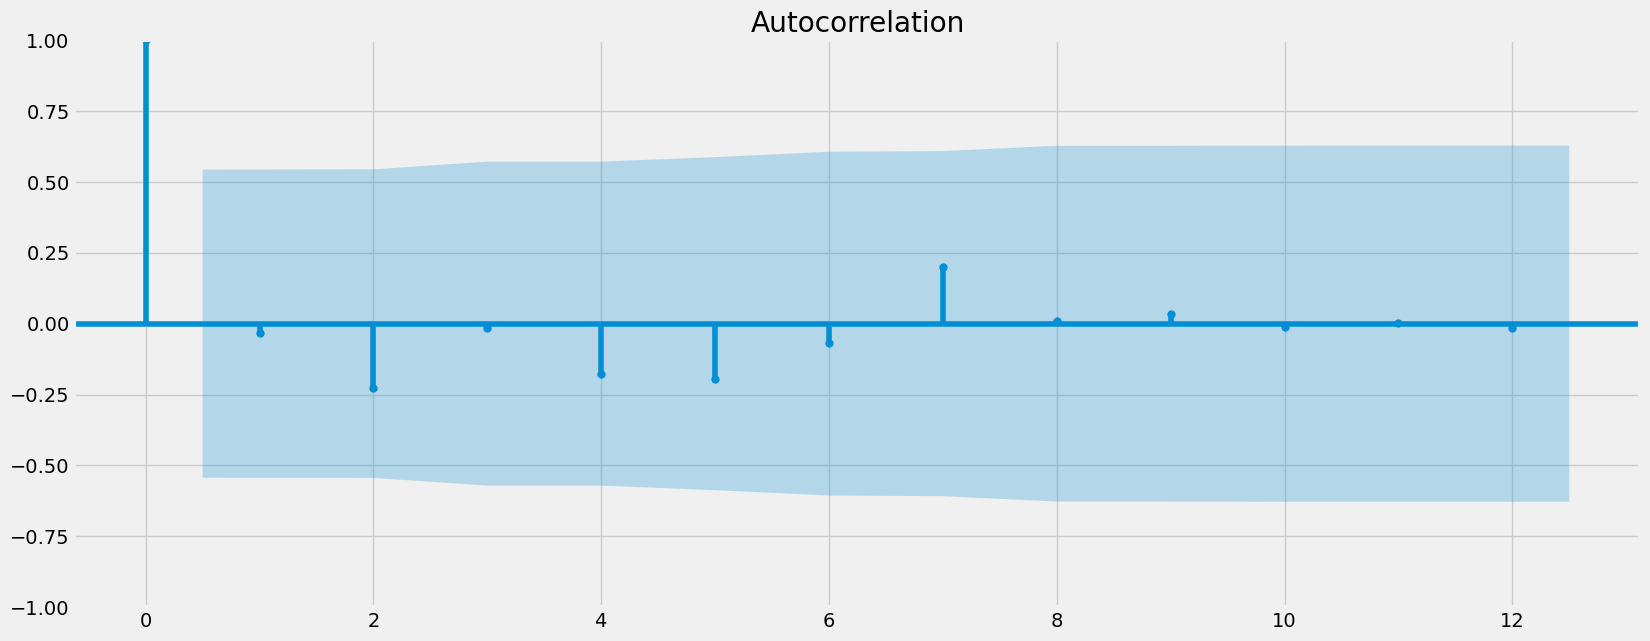

In [145]:
# check the autocorrelations

plot_acf(data_diff)
plt.show()

### Intepretation

With only one out of 13 lags exceeding the confidence level, this implies that there is minimal autocorrelation in the differenced series. This suggests that most of the trend or seasonality has been removed.

## 8. Export data

In [152]:
# exporting df_year_no_dups
df_year_no_dups.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'time_series_year.pkl'))

In [154]:
# exporting differenced series data
data_diff.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'time_series_year_diff.pkl'))